# Evaluate Integrator Accuracy

## RK4

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import matplotlib.pyplot as plt
from itertools import cycle

from jorbit.utils.states import SystemState
from jorbit.integrators import RK4IntegratorState
from jorbit.accelerations import newtonian_gravity
from jorbit.integrators import rk4_evolve

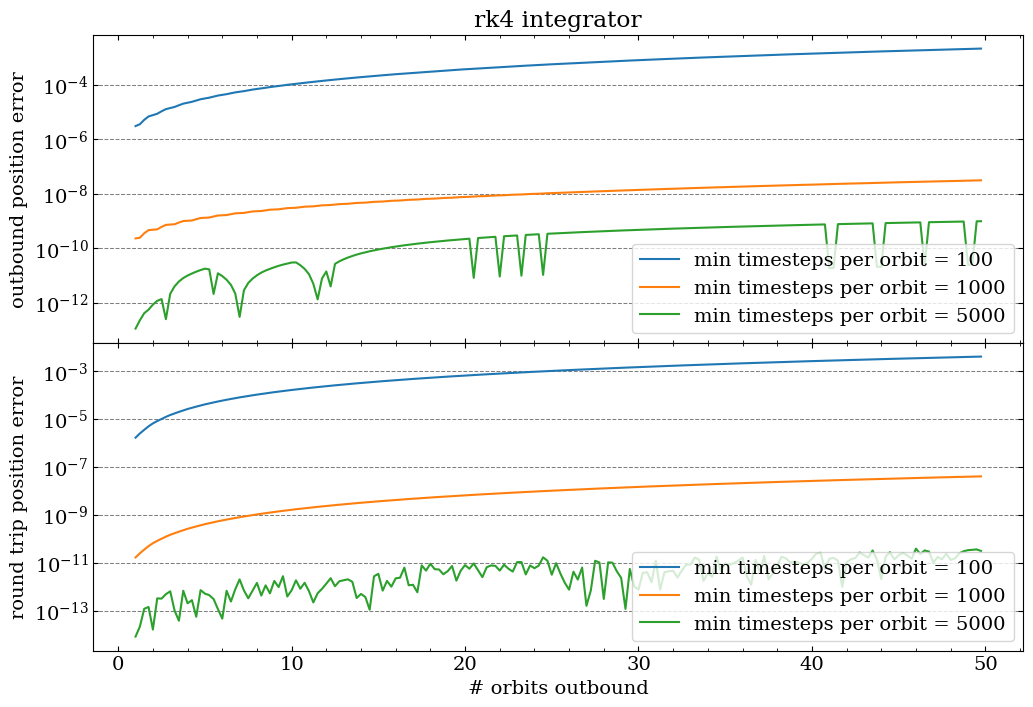

In [2]:
initial_system_state = SystemState(
    positions=jnp.array([[0.0, 0, 0], [1.0, 0, 0]]),
    velocities=jnp.array([[0.0, 0, 0], [0.0, 1.0, 0]]),
    gms=jnp.array([1.0, 0.0]),
    time=0.0,
)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
n_orbits_outbound = jnp.arange(1, 50, 0.25)
acc_func = jax.tree_util.Partial(newtonian_gravity)

outbound_target_positions = cycle(
    [
        jnp.array([1.0, 0.0, 0.0]),
        jnp.array([0.0, 1.0, 0.0]),
        jnp.array([-1.0, 0.0, 0.0]),
        jnp.array([0.0, -1.0, 0.0]),
    ]
)

for min_timesteps_per_orbit in [100, 1_000, 5_000]:
    known_period = 2 * jnp.pi
    dt = known_period / min_timesteps_per_orbit

    initial_integrator_state = RK4IntegratorState(dt=dt)

    outbound_position_errors = []
    round_trip_position_errors = []
    for n_orbits in n_orbits_outbound:
        target = next(outbound_target_positions)
        t_out = 2 * jnp.pi * n_orbits
        new_system_state, new_integrator_state = rk4_evolve(
            initial_system_state,
            acc_func,
            t_out,
            initial_integrator_state,
            int(t_out / initial_integrator_state.dt) + 1,
        )
        outbound_position_errors.append(
            jnp.linalg.norm(new_system_state.positions[1] - target)
        )

        new_system_state, new_integrator_state = rk4_evolve(
            new_system_state,
            acc_func,
            0.0,
            new_integrator_state,
            int(t_out / initial_integrator_state.dt) + 1,
        )
        round_trip_position_errors.append(
            jnp.linalg.norm(new_system_state.positions[1] - jnp.array([1.0, 0.0, 0.0]))
        )

    ax[0].plot(
        n_orbits_outbound,
        outbound_position_errors,
        label=f"min timesteps per orbit = {min_timesteps_per_orbit}",
    )
    ax[1].plot(
        n_orbits_outbound,
        round_trip_position_errors,
        label=f"min timesteps per orbit = {min_timesteps_per_orbit}",
    )

ax[0].set(
    ylabel="outbound position error",
    yscale="log",
    title="rk4 integrator",
)
ax[0].legend()
ax[0].grid(
    which="major", axis="y", color="black", linestyle="--", linewidth=0.75, alpha=0.5
)

ax[1].set(
    xlabel="# orbits outbound",
    ylabel="round trip position error",
    yscale="log",
)
ax[1].legend()
ax[1].grid(
    which="major", axis="y", color="black", linestyle="--", linewidth=0.75, alpha=0.5
)

plt.subplots_adjust(hspace=0.0)

## Leapfrog

In [3]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import matplotlib.pyplot as plt
from itertools import cycle

from jorbit.utils.states import SystemState
from jorbit.integrators import LeapfrogIntegratorState
from jorbit.accelerations import newtonian_gravity

from jorbit.integrators import yoshida_step, leapfrog_evolve
from jorbit.data.constants import Y4_C, Y4_D, Y6_C, Y6_D, Y8_C, Y8_D

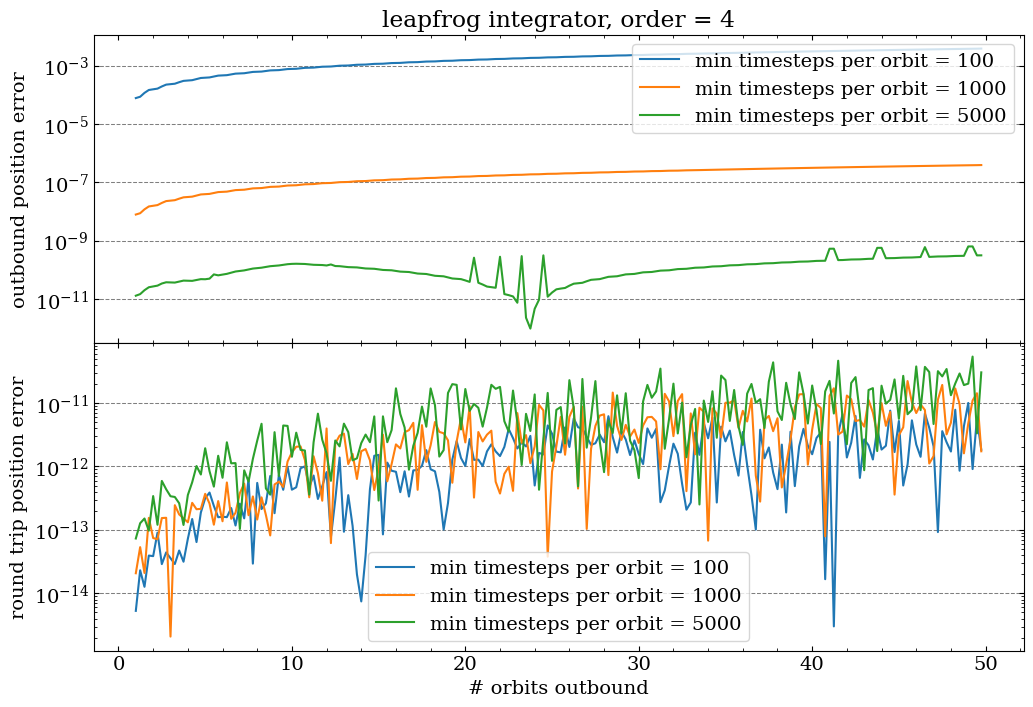

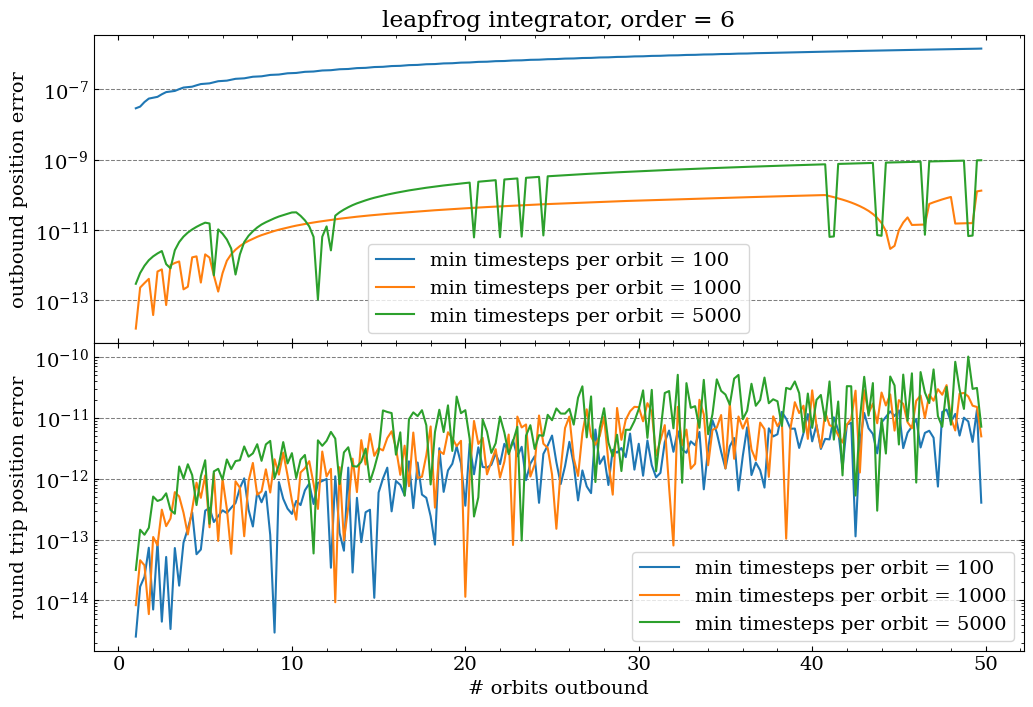

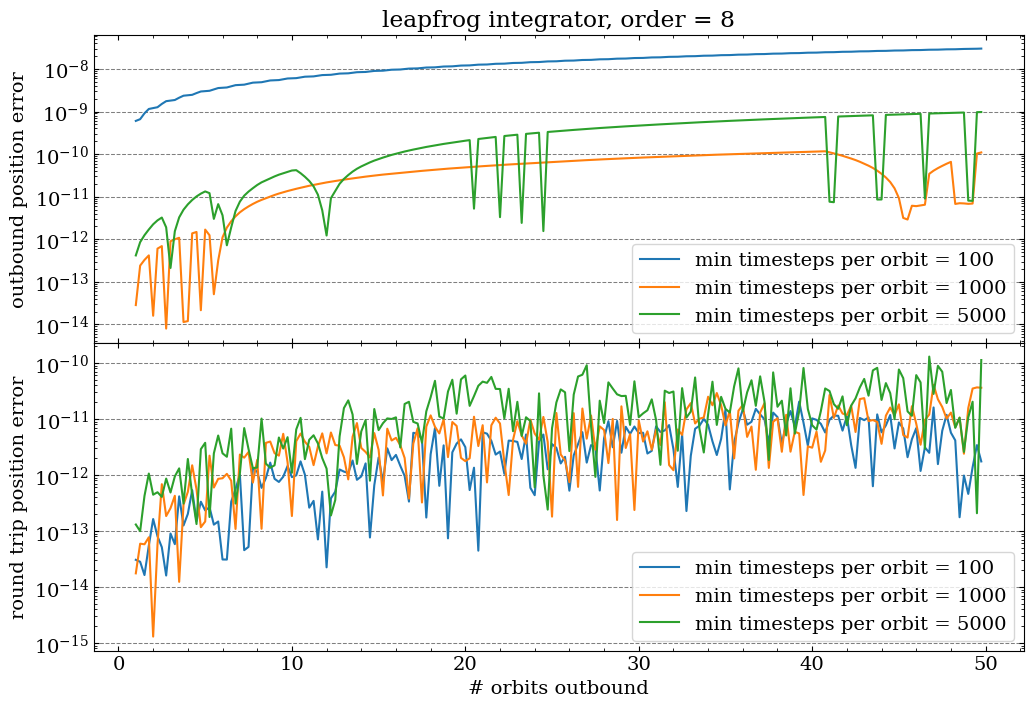

In [4]:
initial_system_state = SystemState(
    positions=jnp.array([[0.0, 0, 0], [1.0, 0, 0]]),
    velocities=jnp.array([[0.0, 0, 0], [0.0, 1.0, 0]]),
    gms=jnp.array([1.0, 0.0]),
    time=0.0,
)


for order in [4, 6, 8]:
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
    n_orbits_outbound = jnp.arange(1, 50, 0.25)
    acc_func = jax.tree_util.Partial(newtonian_gravity)
    outbound_target_positions = cycle(
        [
            jnp.array([1.0, 0.0, 0.0]),
            jnp.array([0.0, 1.0, 0.0]),
            jnp.array([-1.0, 0.0, 0.0]),
            jnp.array([0.0, -1.0, 0.0]),
        ]
    )

    for min_timesteps_per_orbit in [100, 1_000, 5_000]:
        known_period = 2 * jnp.pi
        dt = known_period / min_timesteps_per_orbit

        if order == 4:
            initial_integrator_state = LeapfrogIntegratorState(
                dt=dt, c_coeff=Y4_C, d_coeff=Y4_D
            )
        elif order == 6:
            initial_integrator_state = LeapfrogIntegratorState(
                dt=dt, c_coeff=Y6_C, d_coeff=Y6_D
            )
        elif order == 8:
            initial_integrator_state = LeapfrogIntegratorState(
                dt=dt, c_coeff=Y8_C, d_coeff=Y8_D
            )

        outbound_position_errors = []
        round_trip_position_errors = []
        for n_orbits in n_orbits_outbound:
            target = next(outbound_target_positions)
            t_out = 2 * jnp.pi * n_orbits
            new_system_state, new_integrator_state = leapfrog_evolve(
                initial_system_state,
                acc_func,
                t_out,
                initial_integrator_state,
                int(t_out / initial_integrator_state.dt) + 1,
            )
            outbound_position_errors.append(
                jnp.linalg.norm(new_system_state.positions[1] - target)
            )

            new_system_state, new_integrator_state = leapfrog_evolve(
                new_system_state,
                acc_func,
                0.0,
                new_integrator_state,
                int(t_out / initial_integrator_state.dt) + 1,
            )
            round_trip_position_errors.append(
                jnp.linalg.norm(
                    new_system_state.positions[1] - jnp.array([1.0, 0.0, 0.0])
                )
            )

        ax[0].plot(
            n_orbits_outbound,
            outbound_position_errors,
            label=f"min timesteps per orbit = {min_timesteps_per_orbit}",
        )
        ax[1].plot(
            n_orbits_outbound,
            round_trip_position_errors,
            label=f"min timesteps per orbit = {min_timesteps_per_orbit}",
        )

    ax[0].set(
        ylabel="outbound position error",
        yscale="log",
        title=f"leapfrog integrator, order = {order}",
    )
    ax[0].legend()
    ax[0].grid(
        which="major",
        axis="y",
        color="black",
        linestyle="--",
        linewidth=0.75,
        alpha=0.5,
    )

    ax[1].set(
        xlabel="# orbits outbound",
        ylabel="round trip position error",
        yscale="log",
    )
    ax[1].legend()
    ax[1].grid(
        which="major",
        axis="y",
        color="black",
        linestyle="--",
        linewidth=0.75,
        alpha=0.5,
    )

    plt.subplots_adjust(hspace=0.0)

# IAS15

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import matplotlib.pyplot as plt
from itertools import cycle

from jorbit.utils.states import SystemState
from jorbit.accelerations import newtonian_gravity

from jorbit.integrators import (
    IAS15IntegratorState,
    IAS15Helper,
    initialize_ias15_integrator_state,
)
from jorbit.integrators.ias15 import ias15_step

In [2]:
initial_system_state = SystemState(
    positions=jnp.array([[0.0, 0, 0], [1.0, 0, 0]]),
    velocities=jnp.array([[0.0, 0, 0], [0.0, 1.0, 0]]),
    gms=jnp.array([1.0, 0.0]),
    time=0.0,
)
acc_func = jax.tree_util.Partial(newtonian_gravity)
a0 = acc_func(initial_system_state)

reb = initialize_ias15_integrator_state(n_particles=2, a0=a0)


sysstate, intstate = ias15_step(
    initial_system_state=initial_system_state,
    acceleration_func=acc_func,
    initial_integrator_state=reb,
)

n=0, x=[1. 0. 0.]
n=1, x=[0.99841726 0.05626256 0.        ]
n=2, x=[0.98378417 0.17926479 0.        ]
n=3, x=[0.93846916 0.34535488 0.        ]
n=4, x=[0.8540104  0.52025614 0.        ]
n=5, x=[0.74235505 0.67000079 0.        ]
n=6, x=[0.63303806 0.77411484 0.        ]
n=7, x=[0.5590751  0.82911073 0.        ]
0.0775754560541648




n=0, x=[1. 0. 0.]
n=1, x=[0.99841769 0.05623286 0.        ]
n=2, x=[0.98380048 0.17926653 0.        ]
n=3, x=[0.93846996 0.34536162 0.        ]
n=4, x=[0.85400745 0.52025982 0.        ]
n=5, x=[0.74236213 0.66999945 0.        ]
n=6, x=[0.63304    0.77411899 0.        ]
n=7, x=[0.55908005 0.82911366 0.        ]
0.07964018639420649




n=0, x=[1. 0. 0.]
n=1, x=[0.99841768 0.05623288 0.        ]
n=2, x=[0.98380057 0.17926637 0.        ]
n=3, x=[0.93846947 0.34536222 0.        ]
n=4, x=[0.85400882 0.52025848 0.        ]
n=5, x=[0.74236018 0.67000111 0.        ]
n=6, x=[0.63304109 0.77411812 0.        ]
n=7, x=[0.55907995 0.82911376 0.        ]
0.012488634752493

In [4]:
intstate.dt_last_done, intstate.dt

(0.0, Array(0.17506672, dtype=float64))

In [3]:
jnp.sqrt(999999.8643517571)

Array(999.99993218, dtype=float64, weak_type=True)

In [3]:
from jorbit.data.constants import IAS15_EPSILON

(IAS15_EPSILON * 5040.0) ** (1 / 7)

0.1750670293219

In [4]:
IAS15_EPSILON

1e-09

In [3]:
for k in range(3 * i, 3 * (i + 1)):
    print(k)

NameError: name 'i' is not defined

In [ ]:
reb

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jorbit.integrators.ias15 import add_cs

jax.make_jaxpr(add_cs)(100.001, 0.002, 1e-5)

{ lambda ; a:f64[] b:f64[] c:f64[]. let
    d:f64[] e:f64[] = pjit[
      name=add_cs
      jaxpr={ lambda ; f:f64[] g:f64[] h:f64[]. let
          i:f64[] = sub h g
          j:f64[] = add f i
          k:f64[] = sub j f
          l:f64[] = sub k i
        in (j, l) }
    ] a b c
  in (d, e) }

In [31]:
def add_cs(p, csp, inp):
    y = inp - csp  # equivalent to y = inp - *csp
    t = p + y  # equivalent to t = *p + y
    csp = (t - p) - y  # equivalent to *csp = (t - *p) - y
    p = t  # equivalent to *p = t
    return p, csp


# Assuming that g, b, csb, a0, csa0, gravity_cs, and rr are numpy arrays or lists
rr = [1.0]
g = IAS15Helper(
    p0=jnp.ones((1, 3), dtype=jnp.float64) * 1,
    p1=jnp.ones((1, 3), dtype=jnp.float64) * 1,
    p2=jnp.ones((1, 3), dtype=jnp.float64) * 2,
    p3=jnp.ones((1, 3), dtype=jnp.float64) * 3,
    p4=jnp.ones((1, 3), dtype=jnp.float64) * 4,
    p5=jnp.ones((1, 3), dtype=jnp.float64) * 5,
    p6=jnp.ones((1, 3), dtype=jnp.float64) * 6,
)
b = IAS15Helper(
    p0=jnp.ones((1, 3), dtype=jnp.float64) * 1,
    p1=jnp.ones((1, 3), dtype=jnp.float64) * 1,
    p2=jnp.ones((1, 3), dtype=jnp.float64) * 2,
    p3=jnp.ones((1, 3), dtype=jnp.float64) * 3,
    p4=jnp.ones((1, 3), dtype=jnp.float64) * 4,
    p5=jnp.ones((1, 3), dtype=jnp.float64) * 5,
    p6=jnp.ones((1, 3), dtype=jnp.float64) * 6,
)
gravity_cs = jnp.ones((1, 3), dtype=jnp.float64) * 999
csa0 = gravity_cs

b = IAS15Helper(
    p0=jnp.ones((1, 3), dtype=jnp.float64) * 1,
    p1=jnp.ones((1, 3), dtype=jnp.float64) * 1,
    p2=jnp.ones((1, 3), dtype=jnp.float64) * 1,
    p3=jnp.ones((1, 3), dtype=jnp.float64) * 1,
    p4=jnp.ones((1, 3), dtype=jnp.float64) * 1,
    p5=jnp.ones((1, 3), dtype=jnp.float64) * 1,
    p6=jnp.ones((1, 3), dtype=jnp.float64) * 1,
)
csb = IAS15Helper(
    p0=jnp.ones((1, 3), dtype=jnp.float64) * 1 * 1e-12,
    p1=jnp.ones((1, 3), dtype=jnp.float64) * 1 * 1e-12,
    p2=jnp.ones((1, 3), dtype=jnp.float64) * 1 * 1e-12,
    p3=jnp.ones((1, 3), dtype=jnp.float64) * 1 * 1e-12,
    p4=jnp.ones((1, 3), dtype=jnp.float64) * 1 * 1e-12,
    p5=jnp.ones((1, 3), dtype=jnp.float64) * 1 * 1e-12,
    p6=jnp.ones((1, 3), dtype=jnp.float64) * 1 * 1e-12,
)

a0 = jnp.ones((1, 3), dtype=jnp.float64) * 2
at = jnp.ones((1, 3), dtype=jnp.float64) * 5


tmp = g.p0
gk = at
gk_cs = gravity_cs  # Assuming gravity_cs is a flat array or list

print(gk)
gk, gk_cs = add_cs(gk, gk_cs, -a0)  # Pass gk_cs as a list to simulate pointer behavior
print(gk)
gk, gk_cs = add_cs(gk, gk_cs, csa0)
print(gk)

g.p0 = gk / rr[0]

# Add compensated summation to b.p0[k] and csb.p0[k]
# print(b.p0)
# print(g.p0 - tmp)
# print(csb.p0)
b.p0, csb.p0 = add_cs(b.p0, csb.p0, g.p0 - tmp)
# b.p0

[[5. 5. 5.]]
[[-996. -996. -996.]]
[[3. 3. 3.]]


In [28]:
b.p0[0, 0]

Array(3., dtype=float64)